In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,DepthwiseConv2D,GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
BASE_PATH = '/kaggle/input/skin-cancer-mnist-ham10000/'
IMG_HEIGHT, IMG_WIDTH = 200, 150

In [4]:
metadata_path = os.path.join(BASE_PATH, 'HAM10000_metadata.csv')

In [5]:
def abs_path(x):
    if x +'.jpg' in os.listdir(os.path.join(BASE_PATH, 'HAM10000_images_part_1')):
        return os.path.join(BASE_PATH, 'HAM10000_images_part_1', x +'.jpg')
    elif x +'.jpg' in os.listdir(os.path.join(BASE_PATH, 'HAM10000_images_part_2')):
        return os.path.join(BASE_PATH, 'HAM10000_images_part_2', x +'.jpg')

In [6]:
# Load metadata
metadata = pd.read_csv(metadata_path)
metadata['image_id'] = metadata['image_id'].apply(abs_path)
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,bkl,histo,80.0,male,scalp
1,HAM_0000118,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,bkl,histo,80.0,male,scalp
2,HAM_0002730,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,bkl,histo,80.0,male,scalp
3,HAM_0002730,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,bkl,histo,80.0,male,scalp
4,HAM_0001466,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec,histo,80.0,male,face


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 2., 0., 0.],
        ...,
        [0., 0., 0., ..., 5., 0., 0.],
        [0., 0., 0., ..., 5., 0., 0.],
        [0., 0., 0., ..., 4., 0., 0.]]),
 array([ 68. ,  85.5, 103. , 120.5, 138. , 155.5, 173. , 190.5, 208. ,
        225.5, 243. ]),
 <a list of 600 BarContainer objects>)

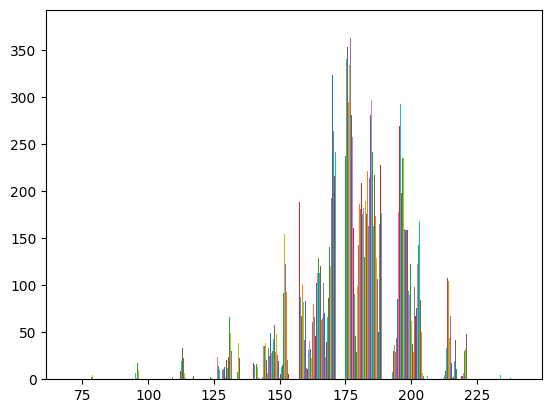

In [8]:
img = cv2.imread(metadata.iloc[0]['image_id'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.hist(img)

In [9]:
img = cv2.imread(metadata.iloc[0]['image_id'])
print(img.shape)

(450, 600, 3)


In [10]:
from tqdm import tqdm
IMG_HEIGHT, IMG_WIDTH = 200, 150
def load_and_resize_image(metadata):
    X = []
    y = []
    for idx,row in tqdm(metadata.iterrows()):
        img = cv2.imread(row['image_id'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = row['dx']
        resized_image = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        resized_image = resized_image/255.0
        X.append(np.array(resized_image))
        y.append(label)
    return np.array(X),np.array(y)
        

In [11]:
X,y = load_and_resize_image(metadata)

10015it [02:43, 61.14it/s]


# lessions types and creating columns

In [12]:
mel='mel'
not_mel='not mel'
metadata['is_mel'] = metadata['dx'].apply(lambda x: mel if x == 'mel' else not_mel)

In [13]:
bkl='bkl'
not_bkl='not bkl'
metadata['is_bkl'] = metadata['dx'].apply(lambda x: bkl if x == 'bkl' else not_bkl)

In [14]:
bcc='bcc'
not_bcc='not bcc'
metadata['is_bcc'] = metadata['dx'].apply(lambda x: bcc if x == 'bcc' else not_bcc)

In [15]:
akiec='akiec'
not_akiec='not akiec'
metadata['is_akiec'] = metadata['dx'].apply(lambda x: akiec if x == 'akiec' else not_akiec)

In [16]:
nv='nv'
not_nv='not nv'
metadata['is_nv'] = metadata['dx'].apply(lambda x: nv if x == 'nv' else not_nv)

In [17]:
vasc='vasc'
not_vasc='not vasc'
metadata['is_vasc'] = metadata['dx'].apply(lambda x: vasc if x == 'vasc' else not_vasc)

In [18]:
df='df'
not_df='not df'
metadata['is_df'] = metadata['dx'].apply(lambda x: df if x == 'df' else not_df)

In [19]:
metadata.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'is_mel', 'is_bkl', 'is_bcc', 'is_akiec', 'is_nv', 'is_vasc', 'is_df'],
      dtype='object')

In [20]:
train_ind, test_ind = train_test_split(np.arange(len(metadata)), test_size=0.2, random_state=42, stratify=y)

In [21]:
test_ind.shape

(2003,)

In [22]:
test_gen, test_cascade = train_test_split(np.arange(len(test_ind)), test_size=0.33, random_state=42, stratify=y[test_ind])

In [23]:
a=metadata[metadata.index.isin(test_ind)].reset_index()

In [24]:
a[a.index.isin(test_gen)]['dx'].value_counts(normalize=True)

dx
nv       0.664680
mel      0.117735
bkl      0.108793
bcc      0.052906
akiec    0.032042
vasc     0.017139
df       0.006706
Name: proportion, dtype: float64

In [25]:
a[a.index.isin(test_cascade)]['dx'].value_counts(normalize=True)

dx
nv       0.679274
bkl      0.111952
mel      0.098336
bcc      0.048411
akiec    0.033283
df       0.021180
vasc     0.007564
Name: proportion, dtype: float64

In [26]:
metadata['dx'].value_counts(normalize=True)

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: proportion, dtype: float64

In [27]:
BATCH_SiZE = 200

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind)],
    #     directory = None,
    x_col = 'image_id',
    y_col = 'is_nv',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )

test_generator = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind[test_gen])],
#     directory = images_dir,
    x_col = 'image_id',
    y_col = 'is_nv',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 7211 validated image filenames belonging to 2 classes.
Found 1342 validated image filenames belonging to 2 classes.


# NV model 

In [28]:
# Define the CNN model
model1 = Sequential()

# Add convolutional layers
model1.add(Conv2D(32, (11, 11), activation='relu', input_shape=(200, 150, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(4, 3)))

model1.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model1.add(Flatten())

# Add fully connected layers
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))  # Dropout for regularization

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model1.add(Dense(2, activation='softmax'))

model1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 190, 140, 32)   │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 41, 40, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,562 (2.37 MB)

 Trainable params: 622,562 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.001)
# Compile the model with the correct optimizer and loss
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_nv.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model1.fit(train_generator, validation_data=test_generator, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745859266.347462     109 service.cc:145] XLA service 0x7c358c00fa10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745859266.347539     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745859266.347545     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745859284.287586     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6717 - loss: 0.6415 - val_accuracy: 0.6699 - val_loss: 0.5575
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7418 - loss: 0.5301 - val_accuracy: 0.6699 - val_loss: 0.5855
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7429 - loss: 0.5042 - val_accuracy: 0.6699 - val_loss: 0.5099
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7471 - loss: 0.4870 - val_accuracy: 0.6699 - val_loss: 0.5045
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7408 - loss: 0.4856 - val_accuracy: 0.6699 - val_loss: 0.4903
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7442 - loss: 0.4657 - val_accuracy: 0.6699 - val_loss: 0.4880
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7421 - loss: 0.4635 - val_accuracy: 0.7362 - val_loss: 0.4852
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7642 - loss: 0.4667 - val_accuracy: 0.7578 - val_loss: 0.4844
Epo

In [91]:
test_loss, test_acc = model1.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100}")

# Save the trained model
model1.save('binary_cascading_nv.keras')

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7526 - loss: 0.4564
Test Accuracy: 81.8926990032196


In [92]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# 1. Predict
y_pred_prob = model1.predict(test_generator)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# 2. True labels
y_true = test_generator.classes

# 3. Get classification report as dictionary
report_dict = classification_report(
    y_true, y_pred_classes, 
    target_names=test_generator.class_indices.keys(), 
    output_dict=True
)

# 4. Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# 5. Format:
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # No rounding
    else:
        return x

report_df = report_df.applymap(format_value_full)

print(report_df)

# 6. Optional: Save to Excel
report_df.to_excel('classification_report_full_precision.xlsx', index=True)


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
              precision    recall  f1-score      support
not nv         0.774725  0.636569  0.698885   443.000000
nv             0.835378  0.908788  0.870538   899.000000
accuracy       0.818927  0.818927  0.818927     0.818927
macro avg      0.805052  0.772678  0.784711  1342.000000
weighted avg   0.815356  0.818927  0.813875  1342.000000


/tmp/ipykernel_30/820493591.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df = report_df.applymap(format_value_full)


In [33]:
test_generator.class_indices

{'not nv': 0, 'nv': 1}

In [34]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator.classes

# 2. Predict PROBABILITIES
y_pred_prob = model1.predict(test_generator)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_nv.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
ROC data saved successfully to 'roc_data.xlsx'.


# Melanoma

In [35]:
nv_indices = metadata[metadata['dx'] == 'nv'].index

In [36]:
train_ind_filtered=np.setdiff1d(train_ind,nv_indices)
test_ind_filtered=np.setdiff1d(test_ind[test_gen],nv_indices)

In [38]:
BATCH_SiZE = 100

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator_mel = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind_filtered)],
    #     directory = None,
    x_col = 'image_id',
    y_col = 'is_mel',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )

test_generator_mel = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind_filtered)],
#     directory = images_dir,
    x_col = 'image_id',
    y_col = 'is_mel',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 2384 validated image filenames belonging to 2 classes.
Found 443 validated image filenames belonging to 2 classes.


In [45]:
# Define the CNN model
model2 = Sequential()

# Add convolutional layers
model2.add(Conv2D(32, (11, 11), activation='relu', input_shape=(200, 150, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(4, 4)))

model2.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model2.add(Flatten())

# Add fully connected layers
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))  # Dropout for regularization

model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model2.add(Dense(2, activation='softmax'))

model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 190, 140, 32)   │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 47, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 41, 29, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 20, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 10, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,258 (2.00 MB)

 Trainable params: 524,258 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_mel.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model2.fit(train_generator_mel, validation_data=test_generator_mel, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 802ms/step - accuracy: 0.6284 - loss: 0.6427 - val_accuracy: 0.6907 - val_loss: 0.5838
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 603ms/step - accuracy: 0.6721 - loss: 0.5929 - val_accuracy: 0.7291 - val_loss: 0.5965
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 614ms/step - accuracy: 0.6868 - loss: 0.5794 - val_accuracy: 0.7427 - val_loss: 0.5260
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 620ms/step - accuracy: 0.7100 - loss: 0.5701 - val_accuracy: 0.7472 - val_loss: 0.5073
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 642ms/step - accuracy: 0.7564 - loss: 0.5148 - val_accuracy: 0.7314 - val_loss: 0.5337
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 630ms/step - accuracy: 0.7669 - loss: 0.5157 - val_accuracy: 0.7585 - val_loss: 0.4931
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 645ms/step - accuracy: 0.7705 - loss: 0.4991 - val_accuracy: 0.7630 - val_loss: 0.4924
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.7804 - loss: 0.4885 - val_accu

In [47]:
test_loss, test_acc = model2.evaluate(test_generator_mel)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model2.save('binary_cascading_mel.keras')

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 558ms/step - accuracy: 0.7720 - loss: 0.5074
Test Accuracy: 0.8013544082641602


In [106]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator_mel.classes

# 2. Predict PROBABILITIES
y_pred_prob = model2.predict(test_generator_mel)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_mel.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step
ROC data saved successfully to 'roc_data.xlsx'.


In [107]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# 1. Evaluate model2
test_loss, test_acc = model2.evaluate(test_generator_mel)
print(f"Test Accuracy: {test_acc}")

# 2. Save model2
model2.save('binary_cascading_mel.keras')

# 3. Predict on test data
y_pred_prob_mel = model2.predict(test_generator_mel)
y_pred_classes_mel = np.argmax(y_pred_prob_mel, axis=1)

# 4. True labels
y_true_mel = test_generator_mel.classes

# 5. Classification report
report_dict_mel = classification_report(
    y_true_mel, y_pred_classes_mel,
    target_names=test_generator_mel.class_indices.keys(),
    output_dict=True
)

# 6. Convert to DataFrame
report_df_mel = pd.DataFrame(report_dict_mel).transpose()

# 7. Formatting: keep full floating point precision
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # No rounding
    else:
        return x

report_df_mel = report_df_mel.applymap(format_value_full)

# 8. Print report
print(report_df_mel)

# 9. Save to Excel
report_df_mel.to_excel('classification_report_model2_mel.xlsx', index=True)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step - accuracy: 0.7720 - loss: 0.5074
Test Accuracy: 0.8013544082641602
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step
              precision    recall  f1-score     support
mel            0.716312  0.677852  0.696552  149.000000
not mel        0.841060  0.863946  0.852349  294.000000
accuracy       0.801354  0.801354  0.801354    0.801354
macro avg      0.778686  0.770899  0.774450  443.000000
weighted avg   0.799102  0.801354  0.799948  443.000000


/tmp/ipykernel_30/4123264382.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df_mel = report_df_mel.applymap(format_value_full)


# Benign keratosis-like lesions

In [49]:
mel_indices= metadata[metadata['dx'] == 'mel'].index

In [50]:
train_ind_bkl=np.setdiff1d(train_ind_filtered,mel_indices)
test_ind_bkl=np.setdiff1d(test_ind_filtered,mel_indices)

In [54]:
BATCH_SiZE = 32

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator_bkl = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind_bkl)],
    #     directory = None,
    x_col = 'image_id',
    y_col = 'is_bkl',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )


test_generator_bkl = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind_bkl)],
#     directory = images_dir,
    x_col = 'image_id',
    y_col = 'is_bkl',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 1583 validated image filenames belonging to 2 classes.
Found 294 validated image filenames belonging to 2 classes.


In [55]:
# Define the CNN model
model3 = Sequential()

# Add convolutional layers
model3.add(Conv2D(32, (11, 11), activation='relu', input_shape=(200, 150, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(4, 4)))

model3.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model3.add(Flatten())

# Add fully connected layers
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))  # Dropout for regularization

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model3.add(Dense(2, activation='softmax'))

model3.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 190, 140, 32)   │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 47, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 41, 29, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 20, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 10, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,258 (2.00 MB)

 Trainable params: 524,258 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_bkl.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model3.fit(train_generator_bkl, validation_data=test_generator_bkl, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.5547 - loss: 0.6876 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.5326 - loss: 0.6905 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.5537 - loss: 0.6876 - val_accuracy: 0.5000 - val_loss: 0.6954
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.5551 - loss: 0.6811 - val_accuracy: 0.5034 - val_loss: 0.6906
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - accuracy: 0.5591 - loss: 0.6707 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 0.5430 - loss: 0.6881 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.5581 - loss: 0.6825 - val_accuracy: 0.5748 - val_loss: 0.6861
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.5442 - loss: 0.6803 - val_accuracy: 0.523

In [57]:
test_loss, test_acc = model3.evaluate(test_generator_bkl)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model3.save('binary_cascading_bkl.keras')

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.7547 - loss: 0.5087
Test Accuracy: 0.7721088528633118


In [60]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator.classes

# 2. Predict PROBABILITIES
y_pred_prob = model3.predict(test_generator)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_bkl.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
ROC data saved successfully to 'roc_data.xlsx'.


In [109]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# 1. Evaluate model
test_loss, test_acc = model3.evaluate(test_generator_bkl)
print(f"Test Accuracy: {test_acc}")

# 2. Save the model
model3.save('binary_cascading_bkl.keras')

# 3. Predict on test data
y_pred_prob_bkl = model3.predict(test_generator_bkl)
y_pred_classes_bkl = np.argmax(y_pred_prob_bkl, axis=1)

# 4. Get true labels
y_true_bkl = test_generator_bkl.classes

# 5. Generate classification report
report_dict_bkl = classification_report(
    y_true_bkl, 
    y_pred_classes_bkl, 
    target_names=test_generator_bkl.class_indices.keys(), 
    output_dict=True
)

# 6. Convert report to DataFrame
report_df_bkl = pd.DataFrame(report_dict_bkl).transpose()

# 7. Formatting: Keep full decimals
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # No rounding
    else:
        return x

report_df_bkl = report_df_bkl.applymap(format_value_full)

# 8. Print report
print(report_df_bkl)

# 9. Save report to Excel
report_df_bkl.to_excel('classification_report_model3_bkl.xlsx', index=True)

print("Classification report saved successfully to 'classification_report_model3_bkl.xlsx'.")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.7547 - loss: 0.5087
Test Accuracy: 0.7721088528633118
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
              precision    recall  f1-score     support
bkl            0.781690  0.755102  0.768166  147.000000
not bkl        0.763158  0.789116  0.775920  147.000000
accuracy       0.772109  0.772109  0.772109    0.772109
macro avg      0.772424  0.772109  0.772043  294.000000
weighted avg   0.772424  0.772109  0.772043  294.000000
Classification report saved successfully to 'classification_report_model3_bkl.xlsx'.


/tmp/ipykernel_30/3633375447.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df_bkl = report_df_bkl.applymap(format_value_full)


# Basal cell carcinoma

In [61]:
bkl_indices= metadata[metadata['dx'] == 'bkl'].index

In [62]:
train_ind_bcc=np.setdiff1d(train_ind_bkl,bkl_indices)
test_ind_bcc=np.setdiff1d(test_ind_bkl,bkl_indices)

In [63]:
BATCH_SiZE = 32

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator_bcc = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind_bcc)],
    #     directory = None,
    x_col = 'image_id',
    y_col = 'is_bcc',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )


test_generator_bcc = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind_bcc)],
#     directory = images_dir,
    x_col = 'image_id',
    y_col = 'is_bcc',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 792 validated image filenames belonging to 2 classes.
Found 147 validated image filenames belonging to 2 classes.


In [64]:
# Define the CNN model
model4 = Sequential()

# Add convolutional layers
model4.add(Conv2D(32, (11, 11), activation='relu', input_shape=(200, 150, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(4, 4)))

model4.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model4.add(Flatten())

# Add fully connected layers
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))  # Dropout for regularization

model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model4.add(Dense(2, activation='softmax'))

model4.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 190, 140, 32)   │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 47, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 41, 29, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 20, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 10, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 8, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 6, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,258 (2.00 MB)

 Trainable params: 524,258 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_3.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model4.fit(train_generator_bcc, validation_data=test_generator_bcc, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 513ms/step - accuracy: 0.5124 - loss: 0.6966 - val_accuracy: 0.5102 - val_loss: 0.6928
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.5278 - loss: 0.6908 - val_accuracy: 0.4694 - val_loss: 0.6959
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.5380 - loss: 0.6865 - val_accuracy: 0.5646 - val_loss: 0.6895
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.5466 - loss: 0.6870 - val_accuracy: 0.6667 - val_loss: 0.6864
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.5672 - loss: 0.6864 - val_accuracy: 0.4830 - val_loss: 0.6872
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.5393 - loss: 0.6837 - val_accuracy: 0.6599 - val_loss: 0.6850
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.5927 - loss: 0.6841 - val_accuracy: 0.6463 - val_loss: 0.6596
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.6180 - loss: 0.6675 - val_accuracy: 0.4898 - val

In [66]:
test_loss, test_acc = model4.evaluate(test_generator_bcc)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model4.save('binary_cascading_bcc.keras')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.6660 - loss: 0.6306
Test Accuracy: 0.6530612111091614


In [67]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator.classes

# 2. Predict PROBABILITIES
y_pred_prob = model4.predict(test_generator)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_bcc.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
ROC data saved successfully to 'roc_data.xlsx'.


In [110]:
y_pred_prob_bcc = model4.predict(test_generator_bcc)
y_pred_classes_bcc = np.argmax(y_pred_prob_bcc, axis=1)

# 4. Get true labels
y_true_bcc = test_generator_bcc.classes

# 5. Generate classification report
report_dict_bcc = classification_report(
    y_true_bcc, 
    y_pred_classes_bcc, 
    target_names=test_generator_bcc.class_indices.keys(), 
    output_dict=True
)

# 6. Convert report to DataFrame
report_df_bcc = pd.DataFrame(report_dict_bcc).transpose()

# 7. Formatting: Full decimals for floats, integers for support
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # Keep full float precision
    else:
        return x

report_df_bcc = report_df_bcc.applymap(format_value_full)

# 8. Print report
print(report_df_bcc)

# 9. Save report to Excel
report_df_bcc.to_excel('classification_report_model4_bcc.xlsx', index=True)

print("Classification report saved successfully to 'classification_report_model4_bcc.xlsx'.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
              precision    recall  f1-score     support
bcc            0.673077  0.507246  0.578512   69.000000
not bcc        0.642105  0.782051  0.705202   78.000000
accuracy       0.653061  0.653061  0.653061    0.653061
macro avg      0.657591  0.644649  0.641857  147.000000
weighted avg   0.656643  0.653061  0.645736  147.000000
Classification report saved successfully to 'classification_report_model4_bcc.xlsx'.


/tmp/ipykernel_30/1791870043.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df_bcc = report_df_bcc.applymap(format_value_full)


# Actinic keratoses and intraepithelial carcinoma

In [68]:
bcc_indices= metadata[metadata['dx'] == 'bcc'].index

In [69]:
train_ind_akiec=np.setdiff1d(train_ind_bcc,bcc_indices)
test_ind_akiec=np.setdiff1d(test_ind_bcc,bcc_indices)

In [70]:
BATCH_SiZE = 32

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator_akiec = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind_akiec)],
    #     directory = None,
    x_col = 'image_id',
    y_col = 'is_akiec',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )

test_generator_akiec = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind_akiec)],
#     directory = images_dir,
    x_col = 'image_id',
    y_col = 'is_akiec',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 422 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.


In [73]:
# Define the CNN model
model5 = Sequential()

# Add convolutional layers
model5.add(Conv2D(32, (11, 11), activation='relu', input_shape=(200, 150, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(4, 4)))

model5.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model5.add(Flatten())

# Add fully connected layers
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.5))  # Dropout for regularization

model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.3))

model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model5.add(Dense(2, activation='softmax'))

model5.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 190, 140, 32)   │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 47, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 41, 29, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 20, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 10, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 8, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 6, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,258 (2.00 MB)

 Trainable params: 524,258 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_akiec.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model5.fit(train_generator_akiec, validation_data=test_generator_akiec, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 642ms/step - accuracy: 0.4604 - loss: 0.6971 - val_accuracy: 0.5641 - val_loss: 0.6829
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5826 - loss: 0.6764 - val_accuracy: 0.5641 - val_loss: 0.6829
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6395 - loss: 0.6521 - val_accuracy: 0.5641 - val_loss: 0.6875
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.6299 - loss: 0.6532 - val_accuracy: 0.5897 - val_loss: 0.6851
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6272 - loss: 0.6683 - val_accuracy: 0.5641 - val_loss: 0.6818
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.6569 - loss: 0.6316 - val_accuracy: 0.6026 - val_loss: 0.6593
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.6926 - loss: 0.6250 - val_accuracy: 0.6282 - val_loss: 0.6369
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7196 - loss: 0.6036 - val_accuracy: 0.7051 - val

In [75]:
test_loss, test_acc = model5.evaluate(test_generator_akiec)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model5.save('binary_cascading_akiec.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.7245 - loss: 0.5083
Test Accuracy: 0.7692307829856873


In [77]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator.classes

# 2. Predict PROBABILITIES
y_pred_prob = model5.predict(test_generator)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_akiec.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
ROC data saved successfully to 'roc_data.xlsx'.


In [111]:
# 3. Predict on test data
y_pred_prob_akiec = model5.predict(test_generator_akiec)
y_pred_classes_akiec = np.argmax(y_pred_prob_akiec, axis=1)

# 4. Get true labels
y_true_akiec = test_generator_akiec.classes

# 5. Generate classification report
report_dict_akiec = classification_report(
    y_true_akiec,
    y_pred_classes_akiec,
    target_names=test_generator_akiec.class_indices.keys(),
    output_dict=True
)

# 6. Convert report to DataFrame
report_df_akiec = pd.DataFrame(report_dict_akiec).transpose()

# 7. Formatting: Full precision for floats, integers for support
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # Keep full float precision
    else:
        return x

report_df_akiec = report_df_akiec.applymap(format_value_full)

# 8. Print report
print(report_df_akiec)

# 9. Save report to Excel
report_df_akiec.to_excel('classification_report_model5_akiec.xlsx', index=True)

print("Classification report saved successfully to 'classification_report_model5_akiec.xlsx'.")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
              precision    recall  f1-score    support
akiec          0.760000  0.863636  0.808511  44.000000
not akiec      0.785714  0.647059  0.709677  34.000000
accuracy       0.769231  0.769231  0.769231   0.769231
macro avg      0.772857  0.755348  0.759094  78.000000
weighted avg   0.771209  0.769231  0.765429  78.000000
Classification report saved successfully to 'classification_report_model5_akiec.xlsx'.


/tmp/ipykernel_30/3116186368.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df_akiec = report_df_akiec.applymap(format_value_full)


# vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)

In [78]:
akiec_indices= metadata[metadata['dx'] == 'akiec'].index

In [79]:
train_ind_vasc=np.setdiff1d(train_ind_akiec,akiec_indices)
test_ind_vasc=np.setdiff1d(test_ind_akiec,akiec_indices)

In [80]:
BATCH_SiZE = 32

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator_vasc = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind_vasc)],
    #     directory = None,
    x_col = 'image_id',
    y_col = 'is_vasc',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )

test_generator_vasc = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind_vasc)],
#     directory = images_dir,
    x_col = 'image_id',
    y_col = 'is_vasc',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 186 validated image filenames belonging to 2 classes.
Found 34 validated image filenames belonging to 2 classes.


In [81]:
# Define the CNN model
model6 = Sequential()

# Add convolutional layers
model6.add(Conv2D(32, (11, 11), activation='relu', input_shape=(200, 150, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(4, 4)))

model6.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model6.add(Flatten())

# Add fully connected layers
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.5))  # Dropout for regularization

model6.add(Dense(64, activation='relu'))
model6.add(Dropout(0.3))

model6.add(Dense(32, activation='relu'))
model6.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model6.add(Dense(2, activation='softmax'))

model6.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 190, 140, 32)   │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 47, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 41, 29, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 20, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 10, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 8, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 6, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,258 (2.00 MB)

 Trainable params: 524,258 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_vascular.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model6.fit(train_generator_vasc, validation_data=test_generator_vasc, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8913 - loss: 0.2391 - val_accuracy: 0.7941 - val_loss: 0.4629
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9091 - loss: 0.2725 - val_accuracy: 0.9412 - val_loss: 0.3149
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8643 - loss: 0.3064 - val_accuracy: 0.8235 - val_loss: 0.3699
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8681 - loss: 0.3024 - val_accuracy: 0.8529 - val_loss: 0.3825
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8944 - loss: 0.2431 - val_accuracy: 0.9412 - val_loss: 0.3229
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9214 - loss: 0.2541 - val_accuracy: 0.8824 - val_loss: 0.3202
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9003 - loss: 0.2608 - val_accuracy: 0.8824 - val_loss: 0.3182


In [84]:
test_loss, test_acc = model6.evaluate(test_generator_vasc)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model6.save('binary_cascading_vascular.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9400 - loss: 0.3213  
Test Accuracy: 0.9411764740943909


In [87]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator.classes

# 2. Predict PROBABILITIES
y_pred_prob = model6.predict(test_generator)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_vasc.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
ROC data saved successfully to 'roc_data.xlsx'.


In [112]:
# 3. Predict on test data
y_pred_prob_vasc = model6.predict(test_generator_vasc)
y_pred_classes_vasc = np.argmax(y_pred_prob_vasc, axis=1)

# 4. Get true labels
y_true_vasc = test_generator_vasc.classes

# 5. Generate classification report
report_dict_vasc = classification_report(
    y_true_vasc,
    y_pred_classes_vasc,
    target_names=test_generator_vasc.class_indices.keys(),
    output_dict=True
)

# 6. Convert report to DataFrame
report_df_vasc = pd.DataFrame(report_dict_vasc).transpose()

# 7. Formatting: Full floats for metrics, integers for support
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)
    else:
        return x

report_df_vasc = report_df_vasc.applymap(format_value_full)

# 8. Print the classification report
print(report_df_vasc)

# 9. Save report to Excel
report_df_vasc.to_excel('classification_report_model6_vasc.xlsx', index=True)

print("Classification report saved successfully to 'classification_report_model6_vasc.xlsx'.")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
              precision    recall  f1-score    support
not vasc       0.933333  0.933333  0.933333  15.000000
vasc           0.947368  0.947368  0.947368  19.000000
accuracy       0.941176  0.941176  0.941176   0.941176
macro avg      0.940351  0.940351  0.940351  34.000000
weighted avg   0.941176  0.941176  0.941176  34.000000
Classification report saved successfully to 'classification_report_model6_vasc.xlsx'.


/tmp/ipykernel_30/1654346283.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df_vasc = report_df_vasc.applymap(format_value_full)


In [93]:
test_dataX = X[test_ind[test_cascade]]
test_dataY = y[test_ind[test_cascade]]
def binary_cascading_classification(test_dataX,classes_dict):
    
    y_pred = []
    for i in range(test_dataX.shape[0]):
        x = np.expand_dims(test_dataX[i],axis=0)
        if classes_dict['Nv'][np.argmax(model1.predict(x))] == 'nv':
            y_pred.append('nv')
        elif classes_dict['Mel'][np.argmax(model2.predict(x))]== 'mel':
            y_pred.append('mel')
        elif classes_dict['Bkl'][np.argmax(model3.predict(x))] == 'bkl':
            y_pred.append('bkl')
        elif classes_dict['Bcc'][np.argmax(model4.predict(x))] == 'bcc':
            y_pred.append('bcc')
        elif classes_dict['Akiec'][np.argmax(model5.predict(x))] == 'akiec':
            y_pred.append('akiec')
        elif classes_dict['Vasc'][np.argmax(model6.predict(x))] == 'vasc':
            y_pred.append('vasc')
        else:
            y_pred.append('df')
    return y_pred

In [102]:
y_pred=binary_cascading_classification(test_dataX,classes_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━

In [ ]:
!pip install reportlab
from reportlab.pdfgen import canvas
from matplotlib.backends.backend_pdf import PdfPages
report = classification_report(test_dataY, y_pred, output_dict=True)
report_str = classification_report(test_dataY, y_pred)

# Save the report as a text in PDF
pdf_filename = 'classification_report.pdf'
c = canvas.Canvas(pdf_filename)
c.drawString(100, 750, report_str)
c.save()

# Alternatively, visualize the classification report as a plot
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.text(0.01, 0.5, report_str, {'fontsize': 12}, fontproperties = 'monospace')
pdf_pages = PdfPages('classification_report_plot.pdf')
pdf_pages.savefig(bbox_inches='tight')
pdf_pages.close()

print("Classification report saved as PDF.")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 7.0 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

Classification report saved as PDF.


In [ ]:
y_prob=model4.predict(test_generator)
class_dict ={0:'not nv', 1:'nv'}
y_pred = []
for ele in y_prob:
    y_pred.append(class_dict[np.argmax(ele)])

In [ ]:
y_true=metadata[metadata.index.isin(test_nv)]['is_nv']

In [ ]:
print(classification_report(y_true,y_pred))

print(train_generator.class_indices)

In [ ]:
print(test_generator.class_indices)

In [98]:
classes_dict={}

In [99]:
classes_dict['Nv']=test_generator.class_indices
classes_dict['Mel']=test_generator_mel.class_indices
classes_dict['Bkl']=test_generator_bkl.class_indices
classes_dict['Bcc']=test_generator_bcc.class_indices
classes_dict['Akiec']=test_generator_akiec.class_indices
classes_dict['Vasc']=test_generator_vasc.class_indices

In [100]:
print(classes_dict)

{'Nv': {'not nv': 0, 'nv': 1}, 'Mel': {'mel': 0, 'not mel': 1}, 'Bkl': {'bkl': 0, 'not bkl': 1}, 'Bcc': {'bcc': 0, 'not bcc': 1}, 'Akiec': {'akiec': 0, 'not akiec': 1}, 'Vasc': {'not vasc': 0, 'vasc': 1}}


In [101]:
classes_dict['Nv'] = {value:key for key,value in test_generator.class_indices.items()}
classes_dict['Mel'] = {value:key for key,value in test_generator_mel.class_indices.items()}
classes_dict['Bkl'] = {value:key for key,value in test_generator_bkl.class_indices.items()}
classes_dict['Bcc'] = {value:key for key,value in test_generator_bcc.class_indices.items()}
classes_dict['Akiec'] = {value:key for key,value in test_generator_akiec.class_indices.items()}
classes_dict['Vasc'] = {value:key for key,value in test_generator_vasc.class_indices.items()}